In [38]:
import os, sys
import iris
import numpy as np
import matplotlib.pyplot as plt

cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)

import timeseries
import general_io as gio

In [1]:
infile_dict = {}
infile_dict['sfc-hflux-from-runoff'] = '/g/data/r87/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/sfc-hflux-from-runoff/gn/v20191112/sfc-hflux-from-runoff-gs_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['sfc-hflux-coupler'] = '/g/data/r87/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/sfc-hflux-coupler/gn/v20191112/sfc-hflux-coupler-gs_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['masso'] = '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/masso/gn/v20191112/masso_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['thetaoga'] = '/g/data/r87/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/thetaoga/gn/v20191112/thetaoga_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'

In [12]:
cp = 3992.10322329649; # J kg-1 degC-1
thetaoga_cube = iris.load_cube(infile_dict['thetaoga'], 'sea_water_potential_temperature')
thetaoga_cube = gio.temperature_unit_check(thetaoga_cube, 'K')
masso_cube = iris.load_cube(infile_dict['masso'], 'sea_water_mass')
ohc_data = masso_cube.data * thetaoga_cube.data * cp
ohc_anomaly_data = ohc_data - ohc_data[0]
thetaoga_anomaly_data = thetaoga_cube.data - thetaoga_cube.data[0]
thermal_data = cp * masso_cube.data[0] * thetaoga_anomaly_data

/g/data/r87/dbi599/miniconda3/envs/ocean3/lib/python3.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1928: UnknownCellMethodWarning: NetCDF variable 'thetaoga' contains unknown cell method 'cell'
  warnings.warn(message=msg, category=UnknownCellMethodWarning)


In [39]:
hfcoupler_cube = iris.load_cube(infile_dict['sfc-hflux-coupler'], 'surface heat flux coming through coupler')
hfcoupler_cube.coord('time').points = masso_cube.coord('time').points
hfcoupler_cube.coord('time').bounds = masso_cube.coord('time').bounds
hfcoupler_cube.coord('time').units = masso_cube.coord('time').units
hfcoupler_cube = timeseries.flux_to_total(hfcoupler_cube)
hfcoupler_cumsum_data = np.cumsum(hfcoupler_cube.data)
hfcoupler_cumsum_anomaly = hfcoupler_cumsum_data - hfcoupler_cumsum_data[0]

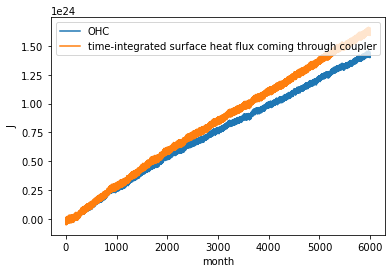

In [42]:
plt.plot(ohc_anomaly_data, label='OHC')
plt.plot(hfcoupler_cumsum_anomaly, label='time-integrated surface heat flux coming through coupler')
plt.ylabel('J')
plt.xlabel('month')
plt.legend()
plt.show()